In [1]:
import osmnx as ox
import networkx as nx

In [2]:
import numpy as np

import json
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
from station_network import *
from bike_service import *

# Información de las estaciones

Buscando en los archivos que https://www.ecobici.cdmx.gob.mx/es/mapa-de-cicloestaciones necesita, encontramos el archivo getJsonObject.json que contiene la información de todas las estaciones de Ecobici. Lo renombramos ecobici_stations.json, lo leemos y lo modificamos un poco.

In [5]:
ecobici_stations = pd.read_json("ecobici_stations.json")

In [6]:
ecobici_stations.set_index('id', inplace=True)

In [7]:
ecobici_stations.head()

,address,addressNumber,bikes,district,lat,lon,name,nearbyStations,slots,stationType,status,zip
id,,,,,,,,,,,,
1,001 - Río Sena-Río Balsas,S/N,26,CUA,19.433571,-99.167809,1 RIO SENA-RIO BALSAS,"3,8,85",1,"BIKE,TPV",OPN,6500.0
2,002 - Río Guadalquivir - Río Balsas,S/N,2,CUA,19.431386,-99.171695,2 RIO GUADALQUIVIR-RIO BALSAS,"1,5",10,BIKE,OPN,6500.0
3,003 - Reforma - Insurgentes,S/N,22,1,19.431655,-99.158668,3 REFORMA-INSURGENTES,"8,20,86",14,"BIKE,TPV",OPN,6500.0
4,004 - Río Nilo - Río Panuco,S/N,7,CUA,19.428309,-99.171713,4 RIO NILO-RIO PANUCO,"5,8,9,10",9,BIKE,OPN,6500.0
5,005 - Río Pánuco Río Tiber,S/N,6,CUA,19.429720,-99.169363,5 RIO PANUCO-RIO TIBER,"2,4,9,10",5,BIKE,OPN,6500.0


In [8]:
no_stations = len(ecobici_stations)
no_stations

480

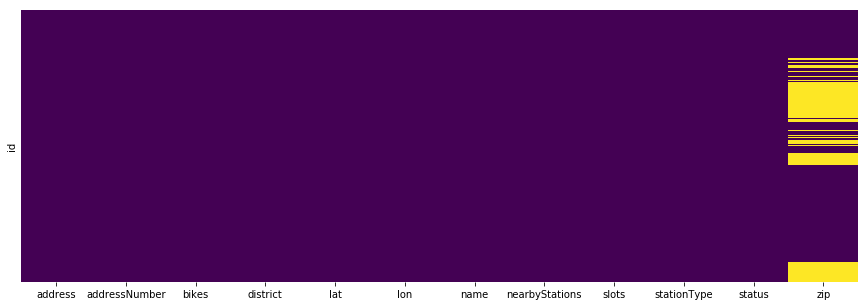

In [9]:
plt.figure(figsize=(15,5))
sns.heatmap(ecobici_stations.isnull(), yticklabels=False, cbar = False, cmap = 'viridis')

# Mapa de las delegaciones en que existe la red de Ecobici

La red de Ecobici abarca sólo unas cuantas delegaciones de la CDMX: Cuauhtémoc, Benito Juárez y Miguel Hidalgo. Entonces le pedimos a OpenStreetMap a través de osmnx que nos muestre únicamente el mapa de esas delegaciones.

In [10]:
# delegaciones en las que hay cobertura de ECOBICI.
delegaciones = ['Cuauhtemoc, Mexico City, Mexico',
                'Benito Juárez, Mexico City, Mexico',
                'Miguel Hidalgo, Mexico City, Mexico']
#ecobici_zone = ox.graph_from_place(delegaciones)

# Viajes

In [11]:
travels = pd.read_csv('2018-09.csv')

Cargamos los nodos más cercanos a cada una de las estaciones como las únicas ubicaciones aproximadas que osmnx le puede asignar a las estaciones.

In [12]:
travels.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo
0,M,72,4025,401,01/09/2018,0:00:03,158,01/09/2018,0:43:22
1,M,30,9367,72,01/09/2018,0:00:11,233,01/09/2018,0:23:41
2,M,29,10220,35,01/09/2018,0:00:22,299,01/09/2018,0:19:33
3,M,26,10619,86,01/09/2018,0:00:25,470,01/09/2018,0:10:52
4,M,21,3882,185,01/09/2018,0:00:28,188,01/09/2018,0:07:22


In [13]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701049 entries, 0 to 701048
Data columns (total 9 columns):
Genero_Usuario           701049 non-null object
Edad_Usuario             701049 non-null int64
Bici                     701049 non-null int64
Ciclo_Estacion_Retiro    701049 non-null int64
Fecha_Retiro             701049 non-null object
Hora_Retiro              701049 non-null object
Ciclo_Estacion_Arribo    701049 non-null int64
Fecha_Arribo             701049 non-null object
Hora_Arribo              701049 non-null object
dtypes: int64(4), object(5)
memory usage: 48.1+ MB


In [14]:
travels['Genero_Usuario'] = travels.Genero_Usuario.astype('category')

Eliminamos información erronea

In [15]:
travels.drop(travels[travels['Ciclo_Estacion_Arribo'] > no_stations].index, inplace=True)
travels.drop(travels[travels['Ciclo_Estacion_Retiro'] > no_stations].index, inplace=True)

In [16]:
travels['Fecha_Hora_Arribo'] = (travels['Fecha_Arribo'] + ' ' + travels['Hora_Arribo']).apply(pd.Timestamp)
travels['Fecha_Hora_Retiro'] = (travels['Fecha_Retiro'] + ' ' + travels['Hora_Retiro']).apply(pd.Timestamp)
travels['Tiempo_Transcurrido']  = (travels['Fecha_Hora_Arribo'] 
                                   - travels['Fecha_Hora_Retiro']).astype('timedelta64[s]')

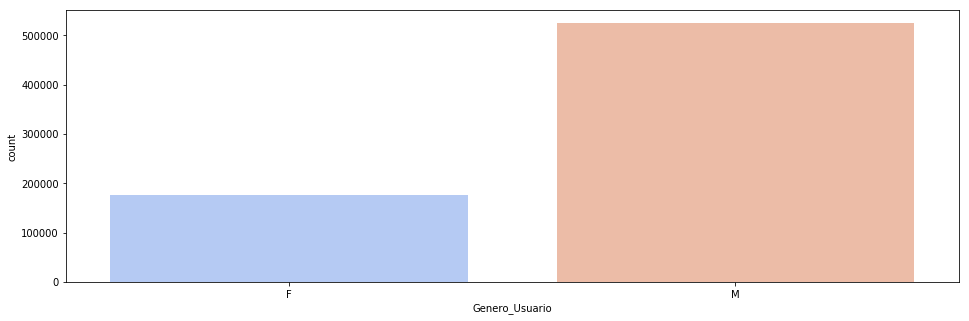

In [17]:
plt.figure(figsize=(16,5))
sns.countplot(travels['Genero_Usuario'], palette='coolwarm')

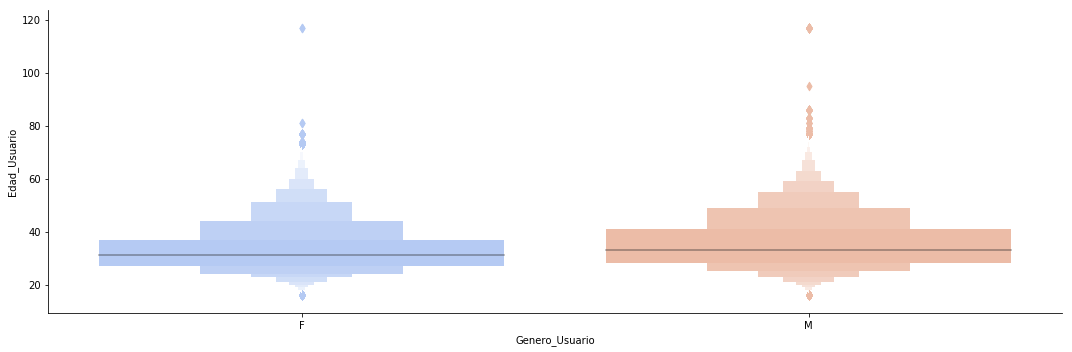

In [18]:
sns.catplot(x = 'Genero_Usuario', y = 'Edad_Usuario', data = travels, 
            height = 5, aspect=3, kind = 'boxen', palette = 'coolwarm')

In [22]:
ecobici_service = BikeService(delegaciones, ecobici_stations, travels)

NameError: name 'metwork_df' is not defined

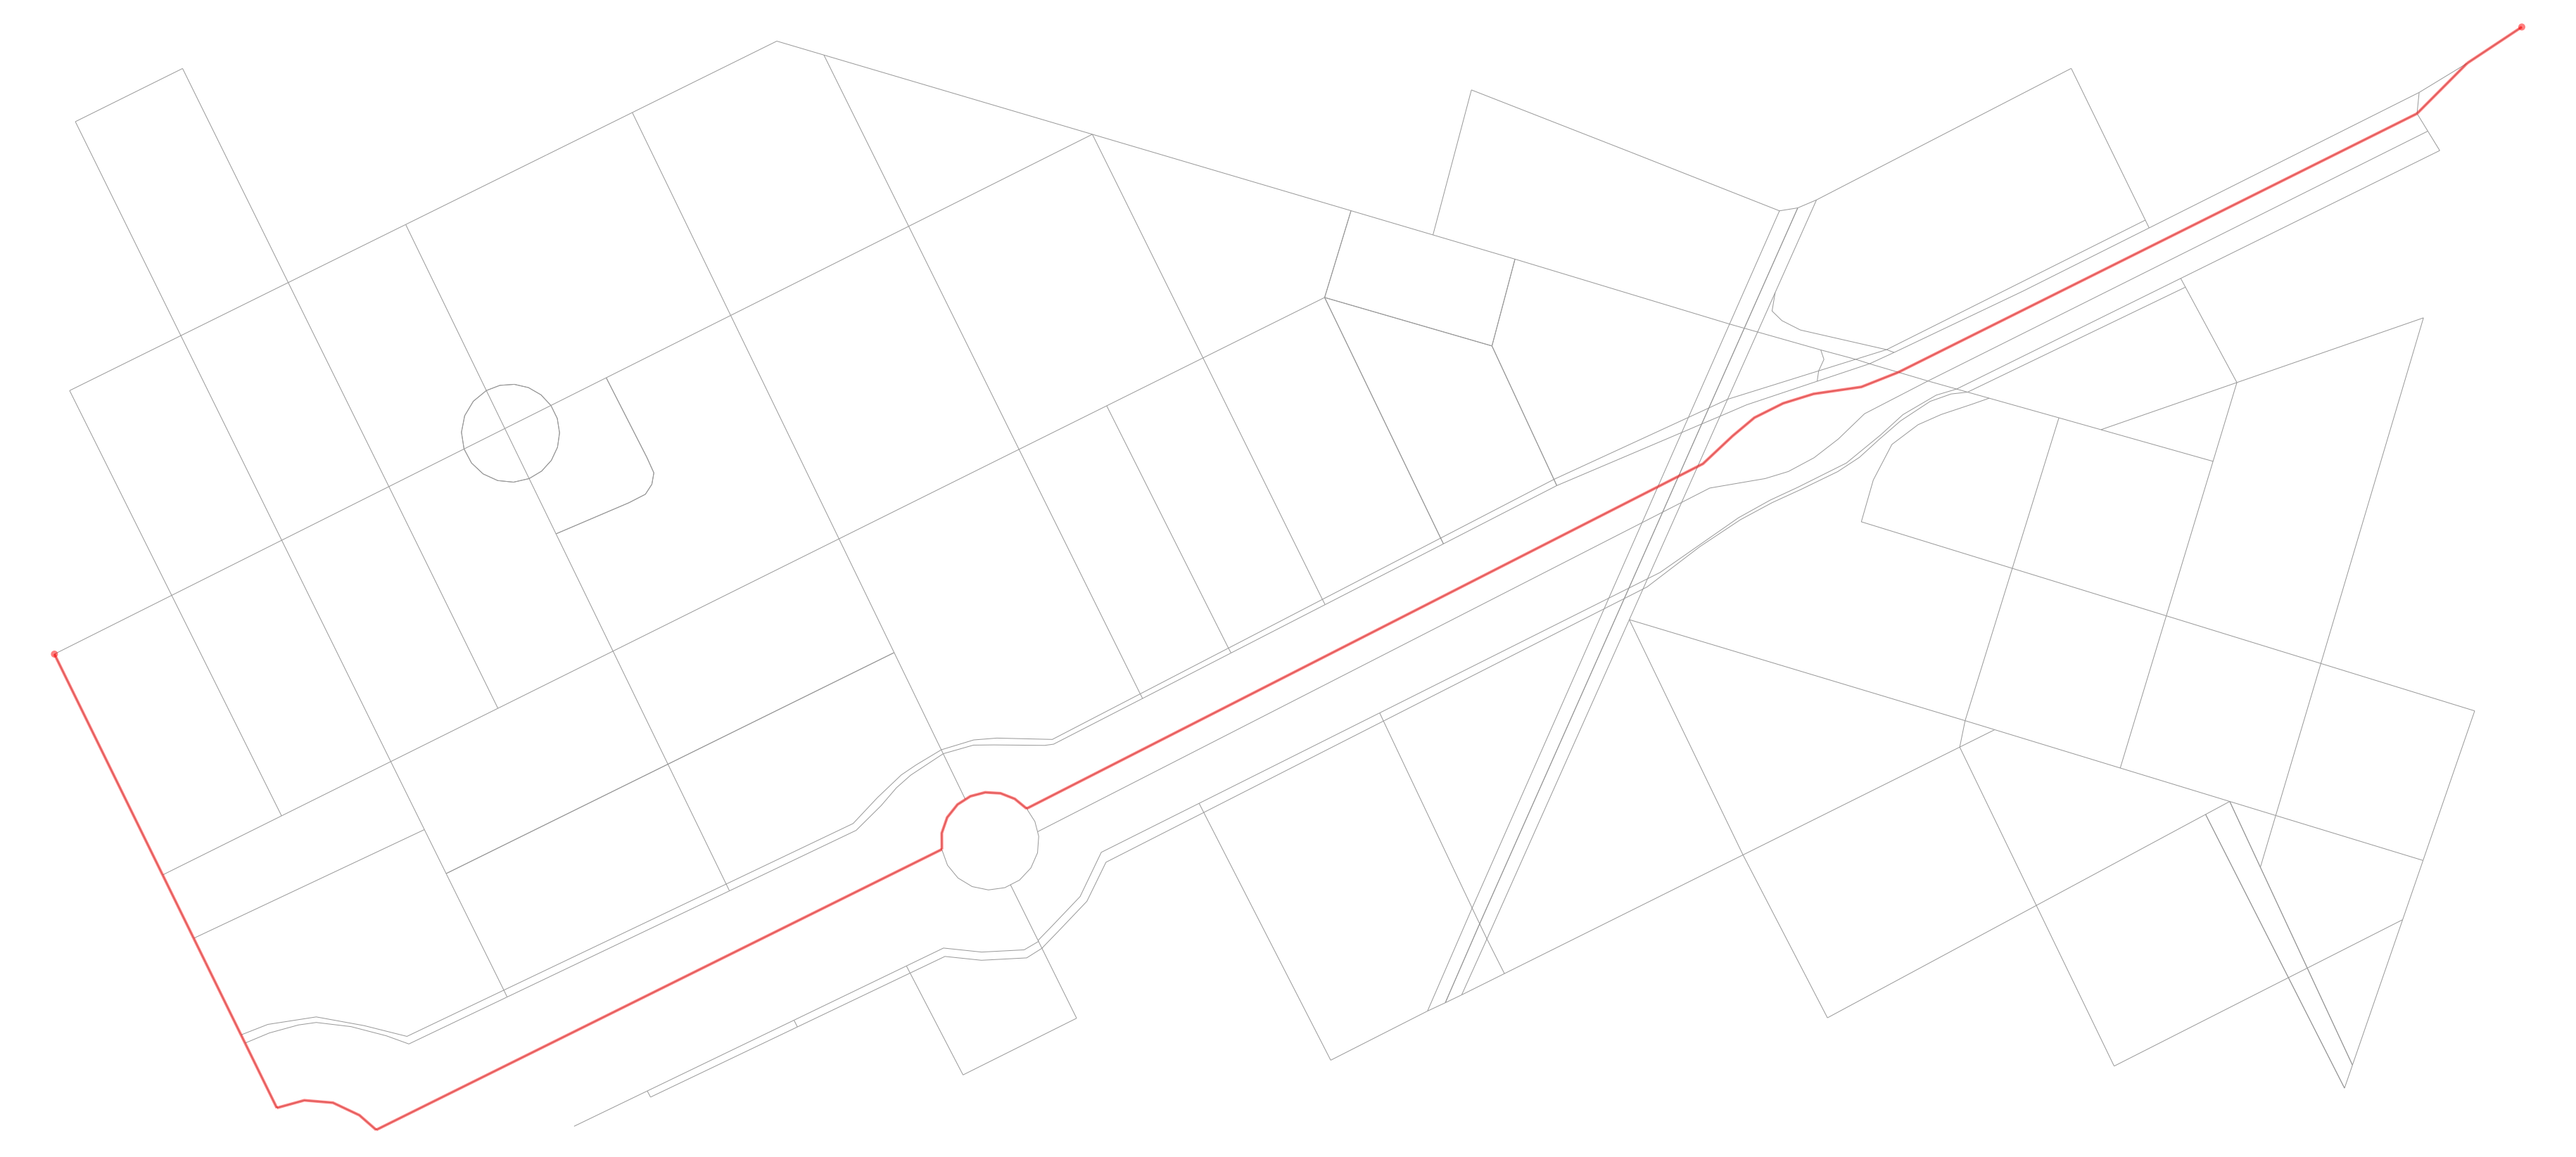

In [13]:
ecobici_service.station(10).plot_shortest_path(5)

El tiempo máximo de uso es 45 minutos (2700 segundos)

/home/pedro/anaconda3/envs/osmnx/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


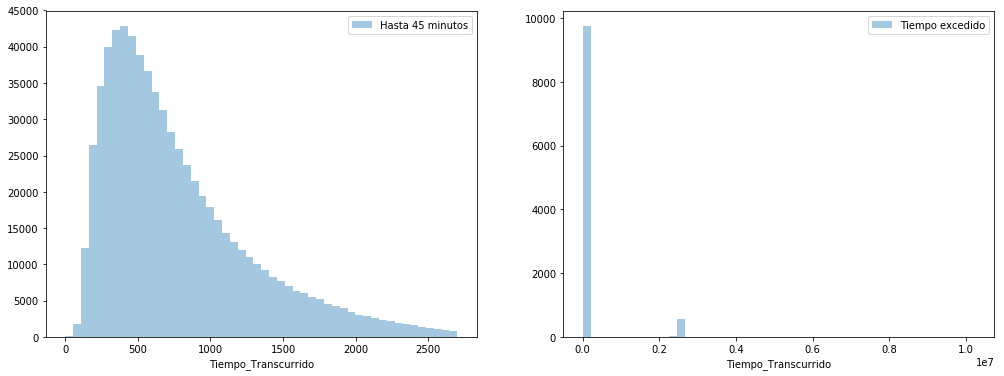

In [29]:
f, ax = plt.subplots(1, 2, figsize=(17, 6))
sns.distplot(travels['Tiempo_Transcurrido'], kde=False, rug=False, ax=ax[0],
             hist_kws={"range": [0,2700]}, label = 'Hasta 45 minutos')
plt.legend()
sns.distplot(travels['Tiempo_Transcurrido'], kde=False, rug=False, ax=ax[1],
             hist_kws={"range": [2700,travels['Tiempo_Transcurrido'].max()]}, label = 'Tiempo excedido')
ax[0].legend()
ax[1].legend()

In [30]:
travels_by_origin_destination = travels.groupby(['Ciclo_Estacion_Retiro', 'Ciclo_Estacion_Arribo'])
travels_by_destination_origin = travels.groupby(['Ciclo_Estacion_Arribo', 'Ciclo_Estacion_Retiro'])

In [35]:
some_station = station_network(10)
some_station.plot_connections()

NameError: name 'ecobici_stations' is not defined